## Quora Questions Similarity Prediction 

### Problem Statement

***While searching through google, we all have come across Quora in search of our answers. Quora is a open source platform where people post their doubts and thoughts. Mostly people post their questions and others answer or show their thought on it.***

***Several users post questions on Quora to get answers and different perspectives from people all around the world. Due to this, one type of question is usually posted many times in different languages and sentences. This leads to excessive use of resources for Quora and chaos for its users. They cannot find an exact and crisp answer for their questions and it leads to wastage of time.***

***This project's objective is to identify the pair of questions which contain two questions with the same meaning using NLP. If the questions which are similar are pooled together along with their answers, the users will get a clear answer for their questions. We are using a dataset provided by Quora. We have two set of questions in each row and we have to classify that are these question duplicate or not.***

**Data Definition:**

**id** - the id of a training set question pair

**qid1, qid2** - unique ids of each question (only available in train.csv)

**question1, question2** - the full text of each question

**is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, nltk, re
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score, confusion_matrix, roc_auc_score
import joblib

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df = pd.read_csv('train.csv')

**Our data is quite huge it has more than 400,000 rows, so we'll slice it and take only 100,000 rows for our training**

In [6]:
train = df[0:100000]

<AxesSubplot:>

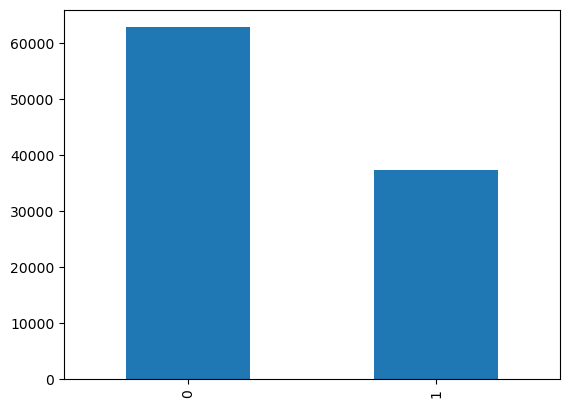

In [7]:
train['is_duplicate'].value_counts().plot(kind = 'bar')

**Text Preprocessing**

In [8]:
def text_preprocess(ques):
    ques = str(ques).lower().strip()

    ques = ques.replace('%',' percent')
    ques = ques.replace('$',' dollar ')
    ques = ques.replace('₹', ' rupee ')
    ques = ques.replace('€', ' euro ')
    ques = ques.replace('@', ' at ')
    ques = ques.replace('[math]','')
    ques = ques.replace(',000,000,000 ', 'b ')
    ques = ques.replace(',000,000 ', 'm ')
    ques = ques.replace(',000 ', 'k ')
    ques = re.sub(r'([0-9]+)000000000', r'\1b', ques)
    ques = re.sub(r'([0-9]+)000000', r'\1m', ques)
    ques = re.sub(r'([0-9]+)000', r'\1k', ques)

    # Decontract words
    
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    decontracted_ques = []

    for word in ques.split():
      if word in contractions:
        word = contractions[word]
      decontracted_ques.append(word)
    
    ques = ' '.join(decontracted_ques)
    ques = ques.replace("'ve", " have")
    ques = ques.replace("n't", " not")
    ques = ques.replace("'re", " are")
    ques = ques.replace("'ll", " will")
    ques = re.sub(r"[^A-Za-z0-9]", " ", ques)
    ques = re.sub('[,\.\(\)?"\']'," ",ques)
    ques = re.sub(r"what's", "", ques)
    ques = re.sub(r"What's", "", ques)
    ques = re.sub(r"\'s", " ", ques)
    ques = re.sub(r"\'ve", " have ", ques)
    ques = re.sub(r"can't", "cannot ", ques)
    ques = re.sub(r"n't", " not ", ques)
    ques = re.sub(r"I'm", "I am", ques)
    ques = re.sub(r" m ", " am ", ques)
    ques = re.sub(r"\'re", " are ", ques)
    ques = re.sub(r"\'d", " would ", ques)
    ques = re.sub(r"\'ll", " will ", ques)
    ques = re.sub(r"\0k ", "0000 ", ques)
    ques = re.sub(r" e g ", " eg ", ques)
    ques = re.sub(r" b g ", " bg ", ques)
    ques = re.sub(r"\0s", "0", ques)
    ques = re.sub(r" 9 11 ", "911", ques)
    ques = re.sub(r"e-mail", "email", ques)
    ques = re.sub(r"\s{2,}", " ", ques)
    ques = re.sub(r"quikly", "quickly", ques)
    ques = re.sub(r" usa ", " America ", ques)
    ques = re.sub(r" USA ", " America ", ques)
    ques = re.sub(r" u s ", " America ", ques)
    ques = re.sub(r" uk ", " England ", ques)
    ques = re.sub(r" UK ", " England ", ques)
    ques = re.sub(r"india", "India", ques)
    ques = re.sub(r"china", "China", ques)
    ques = re.sub(r"chinese", "Chinese", ques) 
    ques = re.sub(r"imrovement", "improvement", ques)
    ques = re.sub(r"intially", "initially", ques)
    ques = re.sub(r"quora", "Quora", ques)
    ques = re.sub(r" dms ", "direct messages ", ques)  
    ques = re.sub(r"demonitization", "demonetization", ques) 
    ques = re.sub(r"actived", "active", ques)
    ques = re.sub(r"kms", " kilometers ", ques)
    ques = re.sub(r"KMs", " kilometers ", ques)
    ques = re.sub(r" cs ", " computer science ", ques) 
    ques = re.sub(r" upvotes ", " up votes ", ques)
    ques = re.sub(r" iPhone ", " phone ", ques)
    ques = re.sub(r"\0rs ", " rs ", ques) 
    ques = re.sub(r"calender", "calendar", ques)
    ques = re.sub(r"ios", "operating system", ques)
    ques = re.sub(r"gps", "GPS", ques)
    ques = re.sub(r"gst", "GST", ques)
    ques = re.sub(r"programing", "programming", ques)
    ques = re.sub(r"bestfriend", "best friend", ques)
    ques = re.sub(r"dna", "DNA", ques)
    ques = re.sub(r"III", "3", ques) 
    ques = re.sub(r"the US", "America", ques)
    ques = re.sub(r"Astrology", "astrology", ques)
    ques = re.sub(r"Method", "method", ques)
    ques = re.sub(r"Find", "find", ques) 
    ques = re.sub(r"banglore", "Banglore", ques)
    ques = re.sub(r" J K ", " JK ", ques)

    # Eliminate HTML tags
    ques = BeautifulSoup(ques)
    ques = ques.get_text()

    # Remove punctuation characters
    pattern = re.compile('\W')
    ques = re.sub(pattern,' ',ques).strip()
    
    return ques

In [9]:
from tqdm import tqdm
tqdm.pandas()

In [10]:
train.question1 = train.question1.progress_apply(text_preprocess)
train.question2 = train.question2.progress_apply(text_preprocess)

100%|█████████████████████████████████| 100000/100000 [00:25<00:00, 3901.84it/s]


In [11]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the Indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...,0
4,4,9,10,which one dissolve in water quickly sugar salt...,which fish would survive in salt water,0


In [12]:
train.shape

(100000, 6)

In [13]:
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [14]:
train.duplicated().sum()

0

In [15]:
train['q1_len'] = train.question1.apply(len)
train['q2_len'] = train.question2.apply(len)

In [16]:
train['q1_num_words'] = train.question1.apply(lambda sent: len(sent.split()))
train['q2_num_words'] = train.question2.apply(lambda sent: len(sent.split()))

In [17]:
def common_words(row):
    wq1 = set(map(lambda x: x.lower().strip(),row['question1'].split()))
    wq2 = set(map(lambda x: x.lower().strip(),row['question2'].split()))
    return len(wq1 & wq2)

In [18]:
train['common_words'] = train.apply(common_words,axis=1)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the Indian government sto...,0,48,85,10,15,7
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...,0,48,54,11,12,0
4,4,9,10,which one dissolve in water quickly sugar salt...,which fish would survive in salt water,0,74,38,13,7,4


In [19]:
def total_words(row):
  wq1 = set(map(lambda x: x.lower().strip(), row['question1'].split()))
  wq2 = set(map(lambda x: x.lower().strip(), row['question2'].split()))
  return len(wq1) + len(wq2)


In [20]:
train['total_words'] = train.apply(total_words,axis=1)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the Indian government sto...,0,48,85,10,15,7,24
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...,0,48,54,11,12,0,20
4,4,9,10,which one dissolve in water quickly sugar salt...,which fish would survive in salt water,0,74,38,13,7,4,20


In [21]:
train['shared_words'] = round(train.common_words / train.total_words,2)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23,0.48
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the Indian government sto...,0,48,85,10,15,7,24,0.29
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24,0.17
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...,0,48,54,11,12,0,20,0.00
4,4,9,10,which one dissolve in water quickly sugar salt...,which fish would survive in salt water,0,74,38,13,7,4,20,0.20


In [22]:
def generate_token_features(row):
  ques1 = row['question1']
  ques2 = row['question2']
  dummy = 0.0001
  token_features = np.zeros((8,),'float32')
  q1_len, q2_len = len(ques1), len(ques2)
  tokens_ques1 = ques1.split()
  tokens_ques2 = ques2.split()

  if len(tokens_ques1) == 0 or len(tokens_ques2) == 0:
    return token_features
  
  non_stopwords_q1 = set([word for word in tokens_ques1 if word not in stopwords.words('english')])
  non_stopwords_q2 = set([word for word in tokens_ques2 if word not in stopwords.words('english')])

  stopwords_q1 = set([word for word in tokens_ques1 if word in stopwords.words('english')])
  stopwords_q2 = set([word for word in tokens_ques2 if word in stopwords.words('english')])
  common_word_count = len(non_stopwords_q1.intersection(non_stopwords_q2))
  common_stop_count = len(stopwords_q1.intersection(stopwords_q2))
  common_token_count = len(set(tokens_ques1).intersection(set(tokens_ques2)))
  
  token_features[0] = common_word_count / (min(q1_len,q2_len) + dummy)
  token_features[1] = common_word_count / (max(q1_len,q2_len) + dummy)
  token_features[2] = common_stop_count / (min(q1_len,q2_len) + dummy)
  token_features[3] = common_stop_count / (max(q1_len,q2_len) + dummy)
  token_features[4] = common_token_count / (min(q1_len,q2_len) + dummy)
  token_features[5] = common_token_count / (max(q1_len,q2_len) + dummy)
  token_features[6] = int(tokens_ques1[0] == tokens_ques2[0])
  token_features[7] = int(tokens_ques1[-1] == tokens_ques2[-1])

  return token_features

In [23]:
token_features = train.progress_apply(generate_token_features,axis=1)

train['cwc_min'] = list(map(lambda x: x[0], token_features))
train['cwc_max'] = list(map(lambda x: x[1], token_features))
train['csc_min'] = list(map(lambda x: x[2], token_features))
train['csc_max'] = list(map(lambda x: x[3], token_features))
train['ctc_min'] = list(map(lambda x: x[4], token_features))
train['ctc_max'] = list(map(lambda x: x[5], token_features))
train['first_word_same'] = list(map(lambda x: x[6], token_features))
train['last_word_same'] = list(map(lambda x: x[7], token_features))

train.head()

100%|██████████████████████████████████| 100000/100000 [08:36<00:00, 193.79it/s]


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,total_words,shared_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_same,last_word_same
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,23,0.48,0.089286,0.076923,0.107143,0.092308,0.196428,0.169231,1.0,0.0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the Indian government sto...,0,48,85,10,15,...,24,0.29,0.083333,0.047059,0.062500,0.035294,0.145833,0.082353,1.0,0.0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,24,0.17,0.034483,0.027778,0.034483,0.027778,0.068965,0.055555,1.0,0.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...,0,48,54,11,12,...,20,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,9,10,which one dissolve in water quickly sugar salt...,which fish would survive in salt water,0,74,38,13,7,...,20,0.20,0.052631,0.027027,0.052631,0.027027,0.105263,0.054054,1.0,0.0


In [24]:
rest_data = train.drop(['id','qid1','qid2','question1','question2'],axis=1)
rest_data.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_same,last_word_same
0,0,65,56,14,12,11,23,0.48,0.089286,0.076923,0.107143,0.092308,0.196428,0.169231,1.0,0.0
1,0,48,85,10,15,7,24,0.29,0.083333,0.047059,0.062500,0.035294,0.145833,0.082353,1.0,0.0
2,0,72,58,14,10,4,24,0.17,0.034483,0.027778,0.034483,0.027778,0.068965,0.055555,1.0,0.0
3,0,48,54,11,12,0,20,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0,74,38,13,7,4,20,0.20,0.052631,0.027027,0.052631,0.027027,0.105263,0.054054,1.0,0.0


In [25]:
rest_data.shape

(100000, 16)

In [26]:
ques_df = train[['question1','question2']]
ques_df.head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor diamond,what would happen if the Indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...
4,which one dissolve in water quickly sugar salt...,which fish would survive in salt water


In [27]:
questions = np.array(list(ques_df.question1) + list(ques_df.question2))
cv = CountVectorizer(max_features=1000)
ques1_arr, ques2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [28]:
q1_temp = pd.DataFrame(ques1_arr)
q2_temp = pd.DataFrame(ques2_arr)
ques = pd.concat([q1_temp,q2_temp],axis=1)
ques.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
ques.index = rest_data.index

In [30]:
df = pd.concat([rest_data,ques],axis=1)
df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,...,990,991,992,993,994,995,996,997,998,999
0,0,65,56,14,12,11,23,0.48,0.089286,0.076923,...,0,0,0,0,0,0,0,0,0,0
1,0,48,85,10,15,7,24,0.29,0.083333,0.047059,...,0,0,0,0,0,0,0,0,0,0
2,0,72,58,14,10,4,24,0.17,0.034483,0.027778,...,0,0,0,0,0,0,0,0,0,0
3,0,48,54,11,12,0,20,0.00,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0,74,38,13,7,4,20,0.20,0.052631,0.027027,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [31]:
X = df.drop('is_duplicate',axis=1)
y = df.is_duplicate

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=101)

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
features = X_train.columns
scaled_X_train = StandardScaler().fit_transform(X)
scaled_X_train = pd.DataFrame(scaled_X_train,columns=features)
scaled_X_train.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,csc_min,...,990,991,992,993,994,995,996,997,998,999
0,0.233581,-0.081460,0.517630,0.096049,1.898801,0.202238,1.816811,1.087703,1.311468,1.408643,...,-0.053104,-0.034079,-0.051709,-0.107015,-0.081972,-0.040044,-0.304719,-0.196529,-0.040058,-0.063034
1,-0.341670,0.781312,-0.199125,0.554844,0.623049,0.318252,0.325405,0.897228,0.178894,0.215767,...,-0.053104,-0.034079,-0.051709,-0.107015,-0.081972,-0.040044,-0.304719,-0.196529,-0.040058,-0.063034
2,0.470449,-0.021958,0.517630,-0.209815,-0.333765,0.318252,-0.616536,-0.665972,-0.552322,-0.532864,...,-0.053104,-0.034079,-0.051709,-0.107015,-0.081972,-0.040044,-0.304719,-0.196529,-0.040058,-0.063034
3,-0.341670,-0.140961,-0.019937,0.096049,-1.609517,-0.145806,-1.950953,-1.769408,-1.605768,-1.454257,...,-0.053104,-0.034079,-0.051709,-0.107015,-0.081972,-0.040044,-0.304719,-0.196529,-0.040058,-0.063034
4,0.538126,-0.616973,0.338441,-0.668610,-0.333765,-0.145806,-0.381051,-0.085218,-0.580793,-0.047921,...,-0.053104,-0.034079,-0.051709,-0.107015,-0.081972,-0.040044,-0.304719,-0.196529,-0.040058,-0.063034


In [35]:
scaled_X_test = StandardScaler().fit_transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=features)
scaled_X_test.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,cwc_min,cwc_max,csc_min,...,990,991,992,993,994,995,996,997,998,999
0,-0.241810,-0.362246,0.322866,-0.058426,-0.977271,0.198738,-1.242566,-1.086692,-0.858097,-0.884367,...,-0.051581,-0.041266,-0.054424,-0.106296,-0.083619,-0.044817,-0.305456,-0.195165,-0.038835,-0.060547
1,-0.903906,-0.854435,-0.724691,-0.691684,0.311537,-0.843290,1.429053,0.303074,0.853321,1.990210,...,-0.051581,-0.041266,-0.054424,-0.106296,-0.083619,-0.044817,2.382234,-0.195165,-0.038835,-0.060547
2,0.155447,0.345275,0.148273,0.258203,-0.332867,0.198738,-0.613950,-0.750192,-0.516501,-0.605075,...,-0.051581,-0.041266,-0.054424,-0.106296,-0.083619,-0.044817,-0.305456,-0.195165,-0.038835,-0.060547
3,0.453390,0.099181,1.195830,0.099889,0.633739,0.661861,0.093243,-0.215329,-0.017451,0.269128,...,-0.051581,-0.041266,-0.054424,8.230674,-0.083619,-0.044817,-0.305456,-0.195165,-0.038835,-0.060547
4,-0.639068,-0.608340,-0.375506,-0.533370,0.633739,-0.495947,1.271899,1.525981,2.303301,0.600104,...,-0.051581,-0.041266,-0.054424,-0.106296,-0.083619,-0.044817,-0.305456,-0.195165,-0.038835,-0.060547


In [36]:
from sklearn.linear_model import LogisticRegression
classifier_logreg = LogisticRegression(solver='liblinear', random_state=0)
classifier_logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

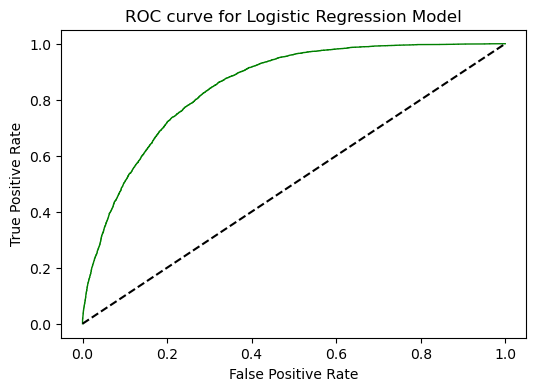

In [37]:
y_pred_logreg_proba = classifier_logreg.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,'-g',linewidth=1)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Logistic Regression Model')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.show()

In [38]:
y_pred_logreg_proba

array([[0.88964388, 0.11035612],
       [0.75965693, 0.24034307],
       [0.96348136, 0.03651864],
       ...,
       [0.60262636, 0.39737364],
       [0.86988145, 0.13011855],
       [0.95698602, 0.04301398]])

In [39]:
pd.DataFrame({"fpr":fpr, "tpr":tpr, "threshold":thresholds})

,fpr,tpr,threshold
0,0.000000,0.000000,1.999734
1,0.000000,0.000134,0.999734
2,0.000000,0.000802,0.998874
3,0.000000,0.001069,0.998837
4,0.000000,0.004277,0.996571
...,...,...,...
6226,0.971241,0.999733,0.003735
6227,0.971241,0.999866,0.003726
6228,0.975555,0.999866,0.003161
6229,0.975555,1.000000,0.003144


In [40]:
#youdenindex 
thresholds[np.argmax(tpr - fpr)]

0.2918468837021402

In [41]:
pred_proba = y_pred_logreg_proba[:,1]

In [42]:
preds = np.where(pred_proba>0.29, 1, 0)

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
print('Accuracy:', accuracy_score(y_test, preds))
print('F1 score:', f1_score(y_test, preds,average='weighted'))
print('Recall:', recall_score(y_test, preds,
                              average='weighted'))
print('Precision:', precision_score(y_test, preds,
                                    average='weighted'))
print('\n AUC:\n',roc_auc_score(y_test, preds))
print('\n clasification report:\n', classification_report(y_test, preds))

Accuracy: 0.7458
F1 score: 0.7496848516842693
Recall: 0.7458
Precision: 0.7883958445094419

 AUC:
 0.7696445800218228

 clasification report:
               precision    recall  f1-score   support

           0       0.89      0.67      0.77     12518
           1       0.61      0.86      0.72      7482

    accuracy                           0.75     20000
   macro avg       0.75      0.77      0.74     20000
weighted avg       0.79      0.75      0.75     20000



Model accuracy: 0.7458


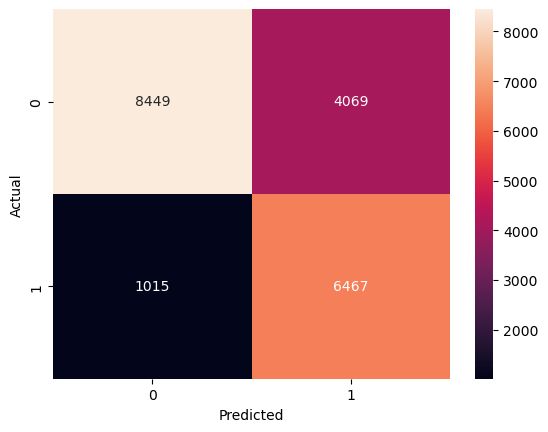

In [45]:
cm = confusion_matrix(y_test, preds)
s = sns.heatmap(cm ,annot=True ,fmt='d')
s.set(xlabel='Predicted', ylabel='Actual')
print("Model accuracy:",accuracy_score(y_test, preds))

In [46]:
cols = ['Model', 'Accuracy', 'F1 Score', 'AUC']

tabulation = pd.DataFrame(columns = cols)

model_metrics = pd.Series({'Model': "Logistic Regression ",
                           'Accuracy':accuracy_score(y_test, preds),
                          'F1 Score': f1_score(y_test, preds,average='weighted'),
                          'AUC' : roc_auc_score(y_test, preds)})
tabulation = tabulation.append(model_metrics, ignore_index = True)

tabulation

,Model,Accuracy,F1 Score,AUC
0,Logistic Regression,0.7458,0.749685,0.769645


## Random Forest 

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
X2 = df.drop('is_duplicate',axis=1)
y2 = df.is_duplicate

In [49]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.25, random_state = 0)

In [50]:
classifier_rf = RandomForestClassifier(n_estimators=800)
classifier_rf.fit(X_train2, y_train2)

RandomForestClassifier(n_estimators=800)

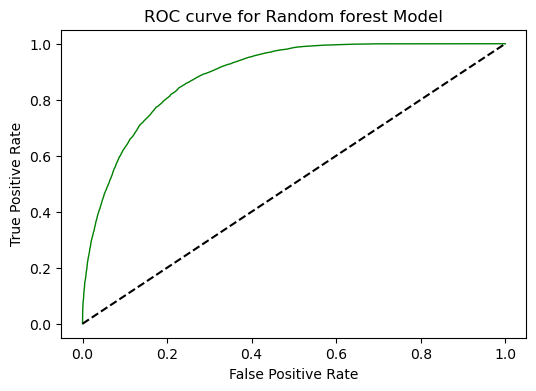

In [51]:
y_pred_proba_rf = classifier_rf.predict_proba(X_test2)
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test2, y_pred_proba_rf[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr_rf,tpr_rf,'-g',linewidth=1)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Random forest Model')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.show()

In [53]:
pred_proba_rf = y_pred_proba_rf[:,1]

In [54]:
preds_rf = np.where(pred_proba_rf>0.50, 1, 0)

Model accuracy: 0.80564


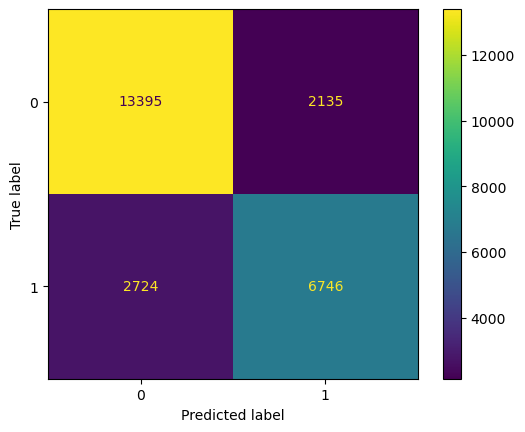

In [57]:
cm_rf = confusion_matrix(y_test2, preds_rf)
ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot()
print("Model accuracy:",accuracy_score(y_test2, preds_rf))

In [58]:
print('Accuracy:', accuracy_score(y_test2, preds_rf))
print('F1 score:', f1_score(y_test2, preds_rf,average='weighted'))
print('Recall:', recall_score(y_test2, preds_rf,
                              average='weighted'))
print('Precision:', precision_score(y_test2, preds_rf,
                                    average='weighted'))
print('\n AUC:\n',roc_auc_score(y_test2, preds_rf))
print('\n clasification report:\n', classification_report(y_test2, preds_rf))

Accuracy: 0.80564
F1 score: 0.8043294343208077
Recall: 0.80564
Precision: 0.8039576335974727

 AUC:
 0.7874394757294362

 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85     15530
           1       0.76      0.71      0.74      9470

    accuracy                           0.81     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.81      0.80     25000



In [59]:
model_metrics1 = pd.Series({'Model': "Random Forest",
                           'Accuracy':accuracy_score(y_test2, preds_rf),
                          'F1 Score': f1_score(y_test2, preds_rf,average='weighted'),
                          'AUC': roc_auc_score(y_test2, preds_rf)})

tabulation = tabulation.append(model_metrics1, ignore_index = True)

In [60]:
tabulation

,Model,Accuracy,F1 Score,AUC
0,Logistic Regression,0.74580,0.749685,0.769645
1,Random Forest,0.80564,0.804329,0.787439


## Decision Tree 

In [61]:
X1 = df.drop('is_duplicate',axis=1)
y1 = df.is_duplicate

In [62]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size = 0.25, random_state = 0)

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [64]:
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_dt.fit(X_train1, y_train1)

DecisionTreeClassifier(random_state=0)

In [65]:
y_pred_logreg_proba_dt = classifier_dt.predict_proba(X_test1)

In [66]:
y_pred_logreg_val_dt = classifier_dt.predict(X_test1)

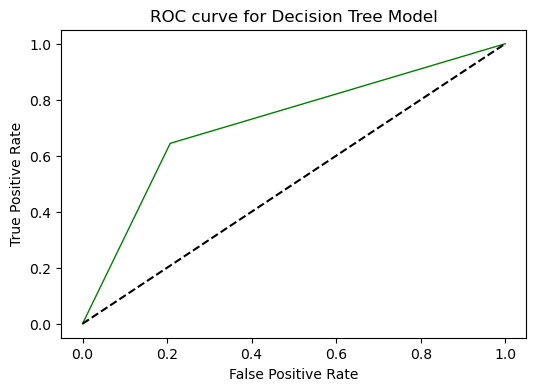

In [67]:
from sklearn.metrics import roc_curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test1, y_pred_logreg_proba_dt[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr_dt,tpr_dt,'-g',linewidth=1)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Decision Tree Model')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.show()

In [68]:
pred_proba_dt = y_pred_logreg_proba_dt[:,1]

In [69]:
preds_dt = np.where(pred_proba_dt>0.50, 1, 0)

In [70]:
print('Accuracy:', accuracy_score(y_test1, preds_dt))
print('F1 score:', f1_score(y_test1, preds_dt,average='weighted'))
print('Recall:', recall_score(y_test1, preds_dt,
                              average='weighted'))
print('Precision:', precision_score(y_test1, preds_dt,
                                    average='weighted'))
print('\n AUC:\n',roc_auc_score(y_test1, preds_dt))
print('\n clasification report:\n', classification_report(y_test1, preds_dt))

Accuracy: 0.73644
F1 score: 0.736024225661392
Recall: 0.73644
Precision: 0.7356617247326658

 AUC:
 0.7184521765619019

 clasification report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     15530
           1       0.65      0.64      0.65      9470

    accuracy                           0.74     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.74      0.74      0.74     25000



Model accuracy: 0.73644


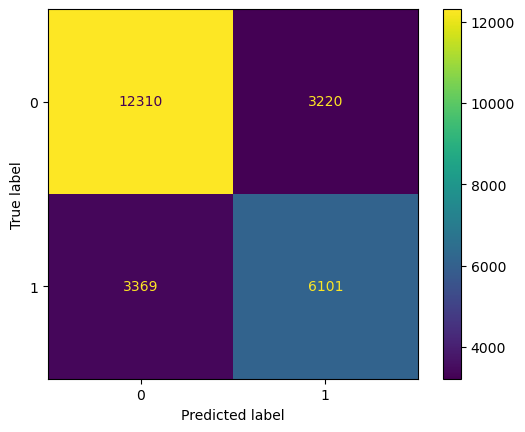

In [71]:
cm_dt = confusion_matrix(y_test1, preds_dt)
ConfusionMatrixDisplay(confusion_matrix=cm_dt).plot()
print("Model accuracy:",accuracy_score(y_test1, preds_dt))

In [72]:
model_metrics2 = pd.Series({'Model': "Descision Tree",
                           'Accuracy':accuracy_score(y_test1, preds_dt),
                          'F1 Score': f1_score(y_test1, preds_dt,average='weighted'),
                          'AUC': roc_auc_score(y_test1, preds_dt)})

tabulation = tabulation.append(model_metrics2, ignore_index = True)

In [73]:
tabulation

,Model,Accuracy,F1 Score,AUC
0,Logistic Regression,0.74580,0.749685,0.769645
1,Random Forest,0.80564,0.804329,0.787439
2,Descision Tree,0.73644,0.736024,0.718452
